<center><h2>Isolation Forest</h2>From scratch</center>

#### Libraries

In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from pprint import pprint
import seaborn as sns
import pdb
sns.set_style(style="whitegrid")
from matplotlib import rcParams

%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'K'
rcParams['figure.figsize'] = 16,8

## Sample data

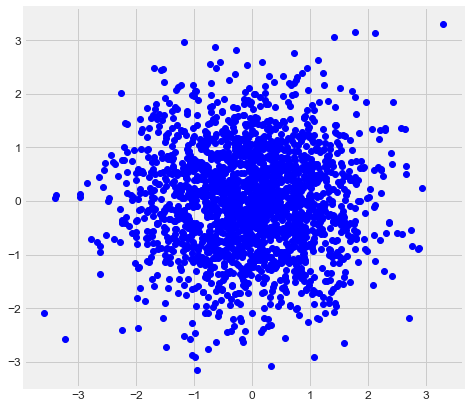

In [3]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
Nobjs = 2000
x, y = np.random.multivariate_normal(mean, cov, Nobjs).T
#Add manual outlier
x[0]=3.3
y[0]=3.3
X=np.array([x,y]).T
X = pd.DataFrame(X,columns=['feat1','feat2'])
plt.figure(figsize=(7,7))
plt.plot(x,y,'bo');
plt.savefig('images/sample.png')
plt.show()

## Isolation tree
 1. Randomly select dimension
 2. Randomly pick a value in the dimension
 3. Split the data


<img src="images/tree_pseudo.png" alt="Drawing" style="width: 400px;"/>

### Select a dimension

In [4]:
def select_feature(data): 
    '''
    Randomly select a feature of a dataframe
    '''
    return random.choice(data.columns)

### Select a value in the dimension

In [5]:
def select_value(data,feat):
    '''
    Select values of 
    '''
    mini = data[feat].min()
    maxi = data[feat].max()
    return (maxi-mini)*np.random.random()+mini
    

In [7]:
var = select_feature(X) 
print(var)
select_value(X,var)

feat2


-2.427891971028951

### Split Data

In [8]:
def split_data(data, split_column, split_value):
    '''
    Split data based on the value of a column
    '''
    data_below = data[data[split_column] <= split_value]
    data_above = data[data[split_column] >  split_value]
    
    return data_below, data_above

In [9]:
var = select_feature(X) 
value = select_value(X,select_feature(X))
print(var,value)
a,b =split_data(X,
           var,
           value)

feat2 -2.7308562661821796


In [10]:
a.shape

(6, 2)

In [11]:
b.shape

(1994, 2)

In [12]:
def classify_data(data):
    
    label_column = data.values[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification
classify_data(X)

-3.151433947295352

### Isolation Tree

<img src="images/tree_pseudo.png" alt="Drawing" style="width: 400px;"/>

In [13]:
def isolation_tree(data,counter=0, max_depth=50):
    
    # End Loop
    if (counter == max_depth) or data.shape[0]<=1:
        classification = classify_data(data)
        return classification
    
    else:
        # Counter
        counter +=1
        
        # Select feature
        split_column = select_feature(data)
        
        # Select value
        split_value = select_value(data,split_column)

        # Split data
        data_below, data_above = split_data(data,split_column,split_value)
        
        # instantiate sub-tree      
        question = "{} <= {}".format(split_column, split_value)
        sub_tree = {question: []}
        
        # Recursive part
        below_answer = isolation_tree(data_below, counter,max_depth=max_depth)
        above_answer = isolation_tree(data_above, counter,max_depth=max_depth)
        
        if below_answer == above_answer:
            sub_tree = below_answer
        else:
            sub_tree[question].append(below_answer)
            sub_tree[question].append(above_answer)
        
        return sub_tree
    
    
        
    

In [14]:
tree = isolation_tree(X, max_depth=1)
pprint(tree)

{'feat2 <= 1.9075625954665596': [-3.151433947295352, 1.9180531945595873]}


# Forest

 1. For each tree
 2. Sample Data
 3. Fit tree

<img src="images/forest_pseudo.png" alt="Drawing" style="width: 400px;"/>

In [15]:
def isolation_forest(df,n_trees=5, max_depth=5, subspace=256):
    forest = []

    for i in range(n_trees):
        # Sample the subspace
        if subspace<=1:
            df = df.sample(frac=subspace)
        else:
            df = df.sample(subspace)
        

        # Fit tree
        tree = isolation_tree(df,max_depth=max_depth)
        
        # Save tree to forest
        forest.append(tree)
    
    return forest
        
        

In [16]:
isolation_forest(X,n_trees=5,max_depth=1)


[{'feat1 <= -1.0934641413547395': [-2.5682668408939806, -2.570872933200529]},
 {'feat1 <= 1.1837443869387005': [-2.570872933200529, -1.5468790931867786]},
 {'feat2 <= -0.6646354195494713': [-2.570872933200529, -0.65953384368241]},
 {'feat2 <= 0.47356257455463835': [-2.570872933200529, 0.4738735906832869]},
 {'feat2 <= -2.5411475181387355': [-2.570872933200529, -2.3261847932986437]}]

## Path Length

<img src="images/path_pseudo.png" alt="Drawing" style="width: 400px;"/>

In [17]:
def pathLength(example,iTree,path=0,trace=False):
    
    path=path+1
    question = list(iTree.keys())[0]
    
    feature_name, comparison_operator, value = question.split()
    
    
    # ask question
    if example[feature_name].values <= float(value):
        answer = iTree[question][0]
    else:
        answer = iTree[question][1]
        
        
    # base case
    if not isinstance(answer, dict):
        return path
    
    # recursive part
    else:
        residual_tree = answer
        return pathLength(example, residual_tree,path=path)

    return path

In [33]:
tree = isolation_tree(X.head(50),max_depth=3)

In [35]:
ins = X.sample(1)
pathLength(ins,tree)

3

# Plotting

In [53]:
def makeline(data,example,iTree,path=0,line_width=1):
    
    #line_width = line_width +2
    path=path+1
    question = list(iTree.keys())[0]
    feature_name, comparison_operator, value = question.split()
    print(question)
    
    # ask question
    if example[feature_name].values <= float(value):
        answer = iTree[question][0]
        data = data[data[feature_name] <= float(value)]
    else:
        answer = iTree[question][1]
        data = data[data[feature_name] > float(value)]
        

    if feature_name == 'feat1':
        plt.hlines(float(value),xmin=data.feat1.min(),xmax=data.feat1.max(),linewidths=line_width)
    else:
        plt.vlines(float(value),ymin=data.feat2.min(),ymax=data.feat2.max(),linewidths=line_width)
             
        
    # base case
    if not isinstance(answer, dict):
        return path
    
    # recursive part
    else:
        if feature_name == 'feat1':
            plt.hlines(float(value),xmin=data.feat1.min(),xmax=data.feat1.max(),linewidths=line_width)
        else:
            plt.vlines(float(value),ymin=data.feat2.min(),ymax=data.feat2.max(),linewidths=line_width)
        residual_tree = answer
        return makeline(data,example, residual_tree,path=path,line_width=line_width)
    
    return path

In [54]:
def make_plot(data,example,iTree):
    plt.figure()
    plt.plot(data['feat1'],data['feat2'],'bo',alpha=0.2)
    plt.xlabel('feat1')
    plt.ylabel('feat2')
    #plt.xlim(data.feat1.min(),data.feat1.max())
    plt.ylim(-3,3)
    plt.xlim(-3,3)
      
    
    # Plot H,v line
    makeline(data,example,tree)
    

    # Plot the point we are looking for
    plt.scatter(x=example.feat1,y=ins.feat2,c='r',marker='o')
    
    plt.show()

        feat1     feat2
142  0.420156 -0.183191
feat1 <= -0.4474945765116678
feat2 <= -0.07954538642763231
feat2 <= -0.2843688278806902


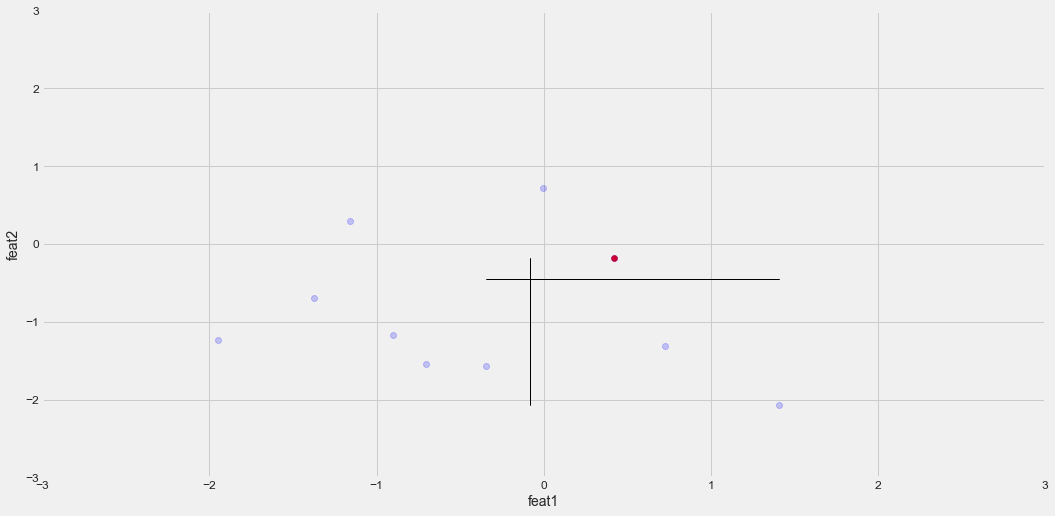

In [67]:
data_plot = X.sample(10)
ins = data_plot.sample(1)
print(ins)

tree = isolation_tree(data_plot,max_depth=50)
make_plot(data_plot,ins,tree)

# Evaluate

In [68]:
iForest = isolation_forest(X,n_trees=20, max_depth=100, subspace=256)

In [69]:
def evaluate_instance(instance,forest):
    paths = []
    for tree in forest:
        paths.append(pathLength(instance,tree))
    return paths 

In [71]:
def c_factor(n) :
    """
    Average path length of unsuccesful search in a binary search tree given n points
    
    Parameters
    ----------
    n : int
        Number of data points for the BST.
    Returns
    -------
    float
        Average path length of unsuccesful search in a BST
        
    """
    return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))

\begin{equation*}
s_{(x,n)} = 2 ^ {-\frac{E(h(x))}{c(n)}}
\end{equation*}

In [72]:
def anomaly_score(data_point,forest,n):
    '''
    Anomaly Score
    
    Returns
    -------
    0.5 -- sample does not have any distinct anomaly
    0 -- Normal Instance
    1 -- An anomaly
    '''
    # Mean depth for an instance
    E = np.mean(evaluate_instance(data_point,forest))
    
    c = c_factor(n)
    
    return 2**-(E/c)

## Evaluate the whole dataset

In [73]:
an= []
for i in range(X.shape[0]):
    an.append(anomaly_score(X.iloc[[i]],iForest,256))

## Evaluate one instance with all the trees

In [74]:
def instance_depth_plot(instance,outlier,forest):
    bars1 = evaluate_instance(outlier,forest)

    bars2 = evaluate_instance(instance,forest)

    # width of the bars
    barWidth = 0.3

    # The x position of bars
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    
    # Create cyan bars
    plt.bar(r2, bars2, width = barWidth, capsize=7, label='Normal Sample')

    # Create blue bars
    plt.bar(r1, bars1, width = barWidth,  capsize=7, label='Outlier')
    #sns.barplot(x=r1, y=bars1,capsize=7, label='Outlier')

    
    #sns.barplot(x=r2, y=bars2, label='Normal')
    
    # general layout

    plt.ylabel('Tree Depth')
    plt.xlabel('Trees')
    plt.legend()

    # Show graphic
    plt.savefig('images/normal_vs_outlier.png')

    plt.show()


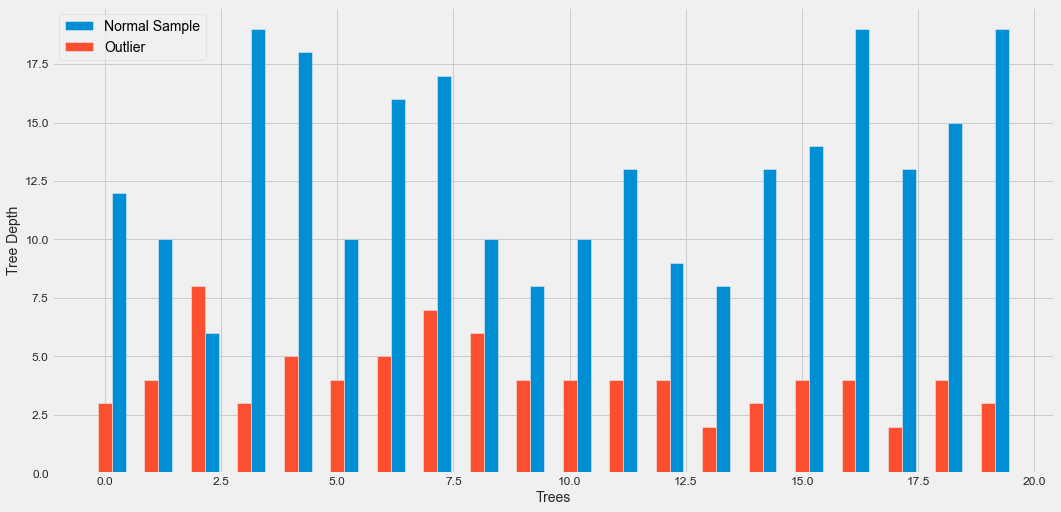

In [76]:
instance_depth_plot(X.sample(1),X.head(1),iForest)

In [77]:
outlier  = evaluate_instance(X.head(1),iForest)
normal  = evaluate_instance(X.sample(1),iForest)

In [80]:
np.mean(outlier)

4.15

In [81]:
np.mean(normal)

10.35

In [106]:
X.shape

(2000, 2)

In [107]:
iForest = isolation_forest(X,n_trees=20, max_depth=100, subspace=1_560)

In [108]:
print('Anomaly score for outlier:',anomaly_score(X.head(1),iForest,1560))
print('Anomaly score for normal:',anomaly_score(X.sample(1),iForest,1560))

Anomaly score for outlier: 0.808515309012463
Anomaly score for normal: 0.458312357739584
